Будем осуществлять работу с непростым набором данных `horse_data.csv` о состоянии здоровья лошадей, испытывающих кишечные колики. Цель – максимально корректно заполнить пропуски.

## Задание 1. Загрузка данных
Изучить представленный набор данных на основе описания его столбцов в файле `horse_data.names` , загрузить его и оставить 8 столбцов для дальнейшего изучения: `surgery?`, `Age`, `rectal temperature`, `pulse`, `respiratory rate`, `temperature of extremities`, `pain`, `outcome`.

In [ ]:
import pandas as pd
import numpy as np

# Задаем порядок колонок
columns_order = [0, 1, 3, 4, 5, 6, 10, 22]

names = {
    0:  'surgery?',
    1:  'Age',
    3:  'rectal temperature',
    4:  'pulse',
    5:  'respiratory rate',
    6:  'temperature of extremities',
    10: 'pain',
    22: 'outcome'
}

horse_data = (pd.read_csv(
    '/content/drive/MyDrive/PYDA/PYDA_HW11/horse_data.csv',
    header=None, na_values='?', usecols=columns_order))

horse_data.columns = [names[column] for column in columns_order]

# в колонке Age предположительно неправильно прочиталось значение 2,
# заменим 9 на 2
horse_data['Age'].replace(9, 2, inplace=True)
horse_data.info()
horse_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery?                    299 non-null    float64
 1   Age                         300 non-null    int64  
 2   rectal temperature          240 non-null    float64
 3   pulse                       276 non-null    float64
 4   respiratory rate            242 non-null    float64
 5   temperature of extremities  244 non-null    float64
 6   pain                        245 non-null    float64
 7   outcome                     299 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 18.9 KB


,surgery?,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,pain,outcome
0,2.0,1,38.5,66.0,28.0,3.0,5.0,2.0
1,1.0,1,39.2,88.0,20.0,NaN,3.0,3.0
2,2.0,1,38.3,40.0,24.0,1.0,3.0,1.0
3,1.0,2,39.1,164.0,84.0,4.0,2.0,2.0
4,2.0,1,37.3,104.0,35.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...
295,1.0,1,NaN,120.0,70.0,4.0,2.0,3.0
296,2.0,1,37.2,72.0,24.0,3.0,4.0,3.0
297,1.0,1,37.5,72.0,30.0,4.0,4.0,2.0
298,1.0,1,36.5,100.0,24.0,3.0,3.0,1.0


## Задание 2. Первичное изучение данных
Проанализировать значения по столбцам, рассчитать базовые статистики, найти выбросы.

### Для непрерывных величин
Выбросы в признаках `rectal temperature, pulse, respiratory rate` являются естественными значениями, а их удаление приведёт к потере важных данных.

#### Базовые статистики

In [ ]:
# Расчёт базовых статистик для непрерывных величин
horse_data[['rectal temperature', 'pulse', 'respiratory rate']].describe()

,rectal temperature,pulse,respiratory rate
count,240.000000,276.000000,242.000000
mean,38.167917,71.913043,30.417355
std,0.732289,28.630557,17.642231
min,35.400000,30.000000,8.000000
25%,37.800000,48.000000,18.500000
50%,38.200000,64.000000,24.500000
75%,38.500000,88.000000,36.000000
max,40.800000,184.000000,96.000000


##### Убедимся что данные распределены нормально
Построим гистограммы

<Axes: >

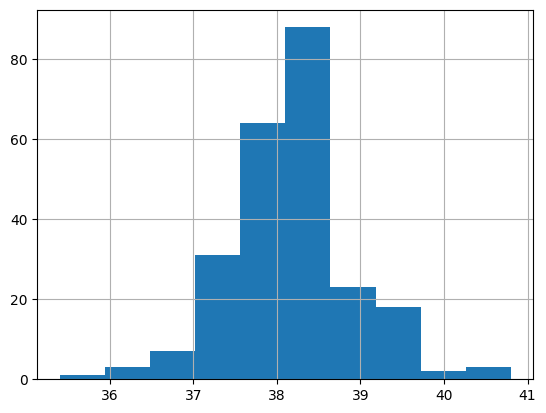

In [ ]:
horse_data['rectal temperature'].hist()

<Axes: >

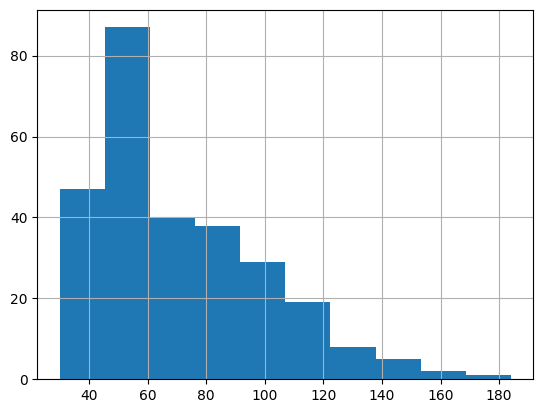

In [ ]:
horse_data['pulse'].hist()

<Axes: >

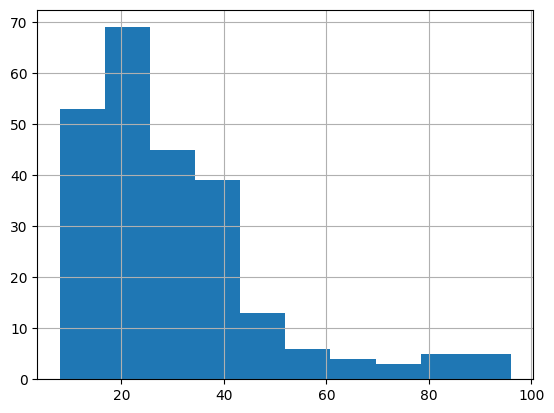

In [ ]:
horse_data['respiratory rate'].hist()

##### Альтернативный способ получения базовой статистики

In [ ]:
columns_to_check = ['rectal temperature', 'pulse',
                    'respiratory rate'] # список колонок

def contin_stat(data, column):
    count = data.count()
    mean = data.mean()
    min = data.min()
    q1 = data.quantile(0.25)
    median = data.median()
    q3 = data.quantile(0.75)
    max = data.max()

    std = data.std()
    var = data.var()


    _df = pd.DataFrame({'count':  [count],
                        'mean':   [mean],
                        'std':    [std],
                        'min':    [min],
                        '25%':    [q1],
                        '50%':    [median],
                        '75%':    [q3],
                        'max':    [max],
                        'var':    [var]}, index=[column])
    return _df


_dfs = []
for column in columns_to_check:
    _df = contin_stat(horse_data[column], column)
    _dfs.append(_df)

_result = pd.concat(_dfs)
base_stat = _result.transpose()
base_stat

,rectal temperature,pulse,respiratory rate
count,240.000000,276.000000,242.000000
mean,38.167917,71.913043,30.417355
std,0.732289,28.630557,17.642231
min,35.400000,30.000000,8.000000
25%,37.800000,48.000000,18.500000
50%,38.200000,64.000000,24.500000
75%,38.500000,88.000000,36.000000
max,40.800000,184.000000,96.000000
var,0.536247,819.708775,311.248328


#### Проанализируем выбросы для каждого признака

##### Посмотрим на значения выбросов

In [ ]:
def outliers_(data,column):
    # поиск и вывод списка выбросов
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = [x for x in data if x > upper_bound or x < lower_bound]
    print(column, 'outliers', ':', outliers)

columns_to_check = ['rectal temperature', 'pulse', 'respiratory rate']

for column in columns_to_check:
    outliers_(horse_data[column], column)

rectal temperature outliers : [39.9, 35.4, 40.3, 39.7, 36.4, 40.3, 39.6, 36.5, 36.0, 36.1, 36.6, 40.8, 40.0, 36.5]
pulse outliers : [164.0, 150.0, 160.0, 184.0, 150.0]
respiratory rate outliers : [84.0, 96.0, 72.0, 80.0, 80.0, 68.0, 96.0, 66.0, 68.0, 90.0, 80.0, 70.0, 88.0, 84.0, 68.0, 90.0, 70.0]


##### rectal temperature
Удаление выбросов практически не влияет на среднее и медиану

In [ ]:
# предварительно уберём пустые значения из колонки
filterna_rectal_temperature = horse_data.dropna(subset='rectal temperature')

In [ ]:
# уберём выбросы для непрерывных величин
q1 = filterna_rectal_temperature['rectal temperature'].quantile(0.25)
q3 = filterna_rectal_temperature['rectal temperature'].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
higher = q3 + (1.5 * iqr)
remove_rectal_temperature_outliers = (filterna_rectal_temperature
                                      [filterna_rectal_temperature
                                      ['rectal temperature']
                                      .between(lower, higher, inclusive=True)])
remove_rectal_temperature_outliers

<ipython-input-7-70de144f4332>:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  [filterna_rectal_temperature


,surgery?,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,pain,outcome
0,2.0,1,38.5,66.0,28.0,3.0,5.0,2.0
1,1.0,1,39.2,88.0,20.0,NaN,3.0,3.0
2,2.0,1,38.3,40.0,24.0,1.0,3.0,1.0
3,1.0,2,39.1,164.0,84.0,4.0,2.0,2.0
4,2.0,1,37.3,104.0,35.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...
292,1.0,1,37.0,66.0,20.0,1.0,4.0,2.0
294,2.0,1,38.5,40.0,16.0,1.0,2.0,1.0
296,2.0,1,37.2,72.0,24.0,3.0,4.0,3.0
297,1.0,1,37.5,72.0,30.0,4.0,4.0,2.0


In [ ]:
print(horse_data['rectal temperature'].mean() - remove_rectal_temperature_outliers['rectal temperature'].mean())

-0.00110988200589901


In [ ]:
print(horse_data['rectal temperature'].median() - remove_rectal_temperature_outliers['rectal temperature'].median())

0.0


##### pulse
Учитывая стандартное отклонение, удаление выбросов практически не влияет на среднее и медиану

In [ ]:
# предварительно уберём пустые значения из колонки
filterna_pulse = horse_data.dropna(subset='pulse')

In [ ]:
# уберём выбросы для непрерывных величин
q1 = filterna_pulse['pulse'].quantile(0.25)
q3 = filterna_pulse['pulse'].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
higher = q3 + (1.5 * iqr)
remove_pulse_outliers = filterna_pulse[filterna_pulse['pulse'].between(lower, higher, inclusive=True)]
remove_pulse_outliers

<ipython-input-12-2df1c2b8886d>:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  remove_pulse_outliers = filterna_pulse[filterna_pulse['pulse'].between(lower, higher, inclusive=True)]


,surgery?,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,pain,outcome
0,2.0,1,38.5,66.0,28.0,3.0,5.0,2.0
1,1.0,1,39.2,88.0,20.0,NaN,3.0,3.0
2,2.0,1,38.3,40.0,24.0,1.0,3.0,1.0
4,2.0,1,37.3,104.0,35.0,NaN,NaN,2.0
6,1.0,1,37.9,48.0,16.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...
295,1.0,1,NaN,120.0,70.0,4.0,2.0,3.0
296,2.0,1,37.2,72.0,24.0,3.0,4.0,3.0
297,1.0,1,37.5,72.0,30.0,4.0,4.0,2.0
298,1.0,1,36.5,100.0,24.0,3.0,3.0,1.0


In [ ]:
print(horse_data['pulse'].mean() - remove_pulse_outliers['pulse'].mean())
print(horse_data['pulse'].std())

1.6547408952350509
28.630556660735


In [ ]:
print(horse_data['pulse'].median() - remove_pulse_outliers['pulse'].median())

0.0


##### respiratory rate
Учитывая стандартное отклонение, удаление выбросов практически не влияет на среднее и медиану

In [ ]:
# предварительно уберём пустые значения из колонки
filterna_respiratory_rate = horse_data.dropna(subset='respiratory rate')

In [ ]:
# уберём выбросы для непрерывных величин
q1 = filterna_respiratory_rate['respiratory rate'].quantile(0.25)
q3 = filterna_respiratory_rate['respiratory rate'].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
higher = q3 + (1.5 * iqr)
remove_respiratory_rate = filterna_respiratory_rate[filterna_respiratory_rate['respiratory rate'].between(lower, higher, inclusive=True)]
remove_respiratory_rate

<ipython-input-16-a821b576f504>:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  remove_respiratory_rate = filterna_respiratory_rate[filterna_respiratory_rate['respiratory rate'].between(lower, higher, inclusive=True)]


,surgery?,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,pain,outcome
0,2.0,1,38.5,66.0,28.0,3.0,5.0,2.0
1,1.0,1,39.2,88.0,20.0,NaN,3.0,3.0
2,2.0,1,38.3,40.0,24.0,1.0,3.0,1.0
4,2.0,1,37.3,104.0,35.0,NaN,NaN,2.0
6,1.0,1,37.9,48.0,16.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...
294,2.0,1,38.5,40.0,16.0,1.0,2.0,1.0
296,2.0,1,37.2,72.0,24.0,3.0,4.0,3.0
297,1.0,1,37.5,72.0,30.0,4.0,4.0,2.0
298,1.0,1,36.5,100.0,24.0,3.0,3.0,1.0


In [ ]:
print(horse_data['respiratory rate'].mean() - remove_pulse_outliers['respiratory rate'].mean())
print(horse_data['respiratory rate'].std())

0.5125934671389203
17.64223138513467


In [ ]:
print(horse_data['respiratory rate'].median() - remove_pulse_outliers['respiratory rate'].median())

-0.5


### Для категориальных признаков
Все наборы категорий соответствуют своему описанию. Аномалий не выявлено. Пропуски в данных вероятно являются ошибками в заполнении информации .

In [ ]:
category_columns = ['surgery?', 'Age', 'temperature of extremities', 'pain', 'outcome']

#### узнаем все уникальные значения в категориях
Все значения соответствую описанию набора данных. Ошибок не найдено кроме пропусков.

In [ ]:
for column in category_columns:
    unique_values = horse_data[column].unique()
    print(column, unique_values)

surgery? [ 2.  1. nan]
Age [1 2]
temperature of extremities [ 3. nan  1.  4.  2.]
pain [ 5.  3.  2. nan  4.  1.]
outcome [ 2.  3.  1. nan]


#### выявим моды для каждого столбца

In [ ]:
print(horse_data[['surgery?', 'Age', 'temperature of extremities', 'pain', 'outcome']].mode())

   surgery?  Age  temperature of extremities  pain  outcome
0       1.0    1                         3.0   3.0      1.0


#### посчитаем количество значений в каждой категории
Малое количество пропусков в колонках `surgery?`, `outcome` и `Age` могут говорить о том, что эти показатели являются наиболее приоритетными и/или лёгкими для заполнения при приёме пациента.

In [ ]:
for column in category_columns:
    value_counts = horse_data[column].value_counts(dropna=False)
    print(value_counts)

1.0    180
2.0    119
NaN      1
Name: surgery?, dtype: int64
1    276
2     24
Name: Age, dtype: int64
3.0    109
1.0     78
NaN     56
2.0     30
4.0     27
Name: temperature of extremities, dtype: int64
3.0    67
2.0    59
NaN    55
5.0    42
4.0    39
1.0    38
Name: pain, dtype: int64
1.0    178
2.0     77
3.0     44
NaN      1
Name: outcome, dtype: int64


## Задание 3. Работа с пропусками
Рассчитать количество пропусков для всех выбранных столбцов. Принять и обосновать решение о методе заполнения пропусков по каждому столбцу на основе рассчитанных статистик и возможной взаимосвязи значений в них. Сформировать датафрейм, в котором пропуски будут отсутствовать.

In [ ]:
# процент пропусков в каждой колонке
(horse_data.isna().mean() * 100).round(2)

surgery?                       0.33
Age                            0.00
rectal temperature            20.00
pulse                          8.00
respiratory rate              19.33
temperature of extremities    18.67
pain                          18.33
outcome                        0.33
dtype: float64

In [ ]:
# количество пропусков в каждой колонке
horse_data.isna().sum()

surgery?                       1
Age                            0
rectal temperature            60
pulse                         24
respiratory rate              58
temperature of extremities    56
pain                          55
outcome                        1
dtype: int64

In [ ]:
# количество и тип данных без пропусков
horse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery?                    299 non-null    float64
 1   Age                         300 non-null    int64  
 2   rectal temperature          240 non-null    float64
 3   pulse                       276 non-null    float64
 4   respiratory rate            242 non-null    float64
 5   temperature of extremities  244 non-null    float64
 6   pain                        245 non-null    float64
 7   outcome                     299 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 18.9 KB


## Рекомендации
Для заполнения пропусков в непрерывных данных:
- не использовать моду
- использовать среднее если нет выбросов
- использовать медиану если есть выбросы
- использовать группировки для более точного подбора значений заполнения

Для заполнения пропусков в категориях:
- лучше использовать моду

Сравнить статистики до и после заполнения пропусков.

In [ ]:
# Непрерывные величины
cont_features = ['rectal temperature', 'pulse', 'respiratory rate']

# Категориальные признаки
cat_features = ['surgery?', 'Age', 'temperature of extremities', 'pain', 'outcome']

## Анализ выбросов и пропусков
Выбросы в непрерывных показателях являются естественными значениями. Их удаление может привести к искаженню данных.

Пропуски
- Непрерывные:
  - `rectal temperature`: заполнить пропуски средним значением
  - `pulse`: проверить связь этого показателя с другими, выявить закономерности и заполнить пропуски на их основе
  - `respiratory rate`: проверить корреляцию с `pulse`, заполнить пропуски средним значением. Cогласно описанию показателя, его полезность сомнительна из-за больших колебаний.

- Категориальные
  - `surgery?` и `outcome`: пропуски заполнить модой.
  - `Age`: нет пропусков
  - `temperature of extremities`: проверить корреляцию с `rectal temperature`, заполнить пропуски модой. Согласно описанию показателя, горячие конечности `(1-2)` должны коррелировать с повышенной ректальной температурой (`rectal temperature`). Холодные конечности `(3-4)` указывают на возможный шок.
  - `pain`: согласно описанию чем выше значение, тем больше вероятность что потребуется операция. Можно проанализировать зависимость данного показателя от других и более точно заполнить пропуски.

In [ ]:
# оставим только те строки, в которых как минимум 3/8 значения заполнено
delete_na = horse_data.copy().dropna(thresh=5)
delete_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 299
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery?                    289 non-null    float64
 1   Age                         290 non-null    int64  
 2   rectal temperature          240 non-null    float64
 3   pulse                       275 non-null    float64
 4   respiratory rate            242 non-null    float64
 5   temperature of extremities  244 non-null    float64
 6   pain                        244 non-null    float64
 7   outcome                     289 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 20.4 KB


### Пропуски в колонке `rectal temperature`

Проверим разницу между базовыми статистиками данных до и после удаления пропусков.

Разницы практически нет.

In [ ]:
print('------Исходные статистики-------')
print(horse_data['rectal temperature'].describe().round(5))
print('------Разница после удаления пропусков только в колонке-------')
print(horse_data['rectal temperature'].describe().round(5) - horse_data.dropna()['rectal temperature'].describe().round(5))
print('------Разница после частичного удаления пропусков-------')
print(horse_data['rectal temperature'].describe().round(5) - horse_data.dropna(thresh=5)['rectal temperature'].describe().round(5))

------Исходные статистики-------
count    240.00000
mean      38.16792
std        0.73229
min       35.40000
25%       37.80000
50%       38.20000
75%       38.50000
max       40.80000
Name: rectal temperature, dtype: float64
------Разница после удаления пропусков только в колонке-------
count    86.00000
mean      0.00428
std       0.00040
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       0.00000
Name: rectal temperature, dtype: float64
------Разница после частичного удаления пропусков-------
count    0.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: rectal temperature, dtype: float64


Заполним пропуски средним значением и сравним статистики. Этот метод подходит для заполнения.

In [ ]:
fill_mean4 = horse_data.copy()
fill_mean4['rectal temperature'] = fill_mean4['rectal temperature'].fillna(horse_data['rectal temperature'].mean())

print('------Исходные статистики-------')
print(horse_data['rectal temperature'].describe().round(5))
print('------Разница после замены------')
print(horse_data['rectal temperature'].describe().round(5) - fill_mean4['rectal temperature'].describe().round(5))

------Исходные статистики-------
count    240.00000
mean      38.16792
std        0.73229
min       35.40000
25%       37.80000
50%       38.20000
75%       38.50000
max       40.80000
Name: rectal temperature, dtype: float64
------Разница после замены------
count   -60.00000
mean      0.00000
std       0.07758
min       0.00000
25%      -0.10000
50%       0.03208
75%       0.00000
max       0.00000
Name: rectal temperature, dtype: float64


### Пропуски в `pulse`

Проверим разницу между базовыми статистиками данных до и после удаления пропусков.

Разницы практически нет.

In [ ]:
print('------Исходные статистики-------')
print(horse_data['pulse'].describe().round(5))
print('------Разница после удаления пропусков только в колонке-------')
print(horse_data['pulse'].describe().round(5) - horse_data.dropna()['pulse'].describe().round(5))
print('------Разница после частичного удаления пропусков-------')
print(horse_data['pulse'].describe().round(5) - horse_data.dropna(thresh=5)['pulse'].describe().round(5))

------Исходные статистики-------
count    276.00000
mean      71.91304
std       28.63056
min       30.00000
25%       48.00000
50%       64.00000
75%       88.00000
max      184.00000
Name: pulse, dtype: float64
------Разница после удаления пропусков только в колонке-------
count    122.00000
mean       1.06888
std       -0.97913
min       -6.00000
25%        0.00000
50%        4.00000
75%        0.00000
max        0.00000
Name: pulse, dtype: float64
------Разница после частичного удаления пропусков-------
count    1.00000
mean     0.01486
std     -0.05113
min      0.00000
25%      0.00000
50%      0.00000
75%      0.00000
max      0.00000
Name: pulse, dtype: float64


Заполним пропуски средним значением и сравним статистики. Этот метод подходит для заполнения.

In [ ]:
fill_mean5 = horse_data.copy()
fill_mean5['pulse'] = fill_mean4['pulse'].fillna(horse_data['pulse'].mean())

print('------Исходные статистики-------')
print(horse_data['pulse'].describe().round(5))
print('------Разница после замены------')
print(horse_data['pulse'].describe().round(5) - fill_mean5['pulse'].describe().round(5))

------Исходные статистики-------
count    276.00000
mean      71.91304
std       28.63056
min       30.00000
25%       48.00000
50%       64.00000
75%       88.00000
max      184.00000
Name: pulse, dtype: float64
------Разница после замены------
count   -24.00000
mean      0.00000
std       1.17309
min       0.00000
25%       0.00000
50%      -4.00000
75%       0.00000
max       0.00000
Name: pulse, dtype: float64


Проверим корреляцию всех показателей набора данных друг с другом.

<Axes: >

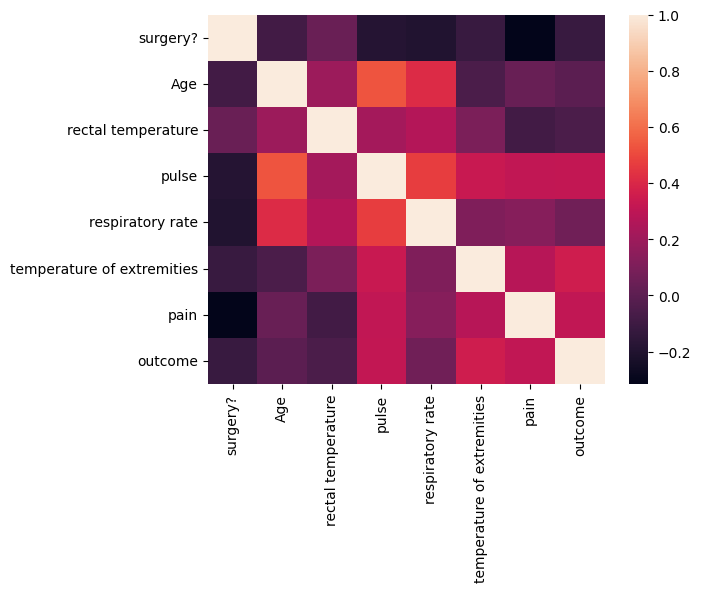

In [ ]:
import seaborn as sns

t = horse_data[['surgery?', 'Age', 'rectal temperature', 'pulse', 'respiratory rate', 'temperature of extremities', 'pain', 'outcome']].corr()
sns.heatmap(t)


Проверим зависимость `pulse` от других показателей. Увидим что чем выше значение `respiratory rate`, тем выше среднее значение `pulse`.

In [ ]:
hd = horse_data.copy()
hd['pulse'] = pd.cut(horse_data['pulse'],8)
hd.groupby('pulse',dropna=False)['respiratory rate'].agg(['count','mean'])

,count,mean
pulse,,
"(29.846, 49.25]",69,20.956522
"(49.25, 68.5]",69,30.289855
"(68.5, 87.75]",34,31.470588
"(87.75, 107.0]",33,35.545455
"(107.0, 126.25]",18,40.722222
"(126.25, 145.5]",7,42.857143
"(145.5, 164.75]",5,64.400000
"(164.75, 184.0]",1,84.000000


<Axes: xlabel='pulse'>

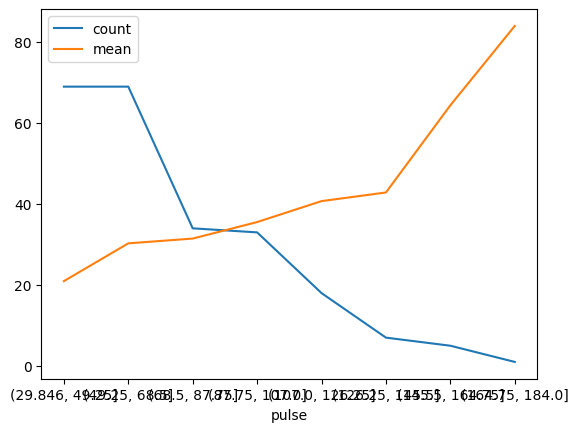

In [ ]:
hd.groupby('pulse',dropna=False)['respiratory rate'].agg(['count','mean']).plot()

<Axes: xlabel='respiratory rate'>

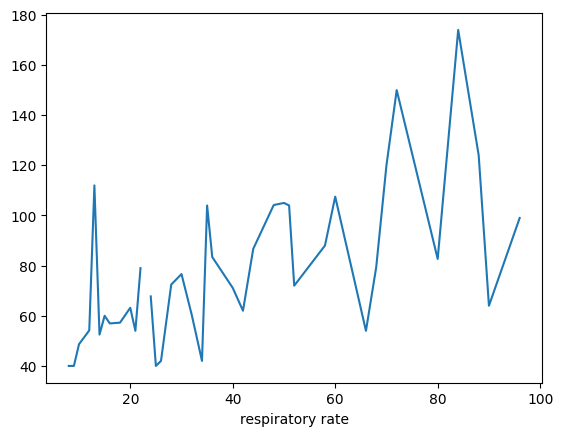

In [ ]:
horse_data.groupby(['respiratory rate'])['pulse'].mean().plot()

### Пропуски в `respiratory rate`
Сравним базовые статистики до и после замены пропусков средним значением.

Увидим, что расхождений с исходными данными практически нет. Используем среднее для финального датафрейма.

In [ ]:
# посмотрим на базовую статистику исходных данных
print('---orig---')
print(horse_data['respiratory rate'].describe())

# заполним пропуски средним и сравним статистики
fill_mean6 = horse_data.copy()
fill_mean6['respiratory rate'] = (fill_mean6['respiratory rate']
                                  .fillna(horse_data['respiratory rate']
                                          .mean()))
print('---mean---')
print(horse_data['respiratory rate'].describe()
      - fill_mean6['respiratory rate'].describe())

---orig---
count    242.000000
mean      30.417355
std       17.642231
min        8.000000
25%       18.500000
50%       24.500000
75%       36.000000
max       96.000000
Name: respiratory rate, dtype: float64
---mean---
count   -5.800000e+01
mean    -3.552714e-15
std      1.803279e+00
min      0.000000e+00
25%     -1.500000e+00
50%     -5.500000e+00
75%      1.750000e+00
max      0.000000e+00
Name: respiratory rate, dtype: float64


### Пропуски в `temperature of extremities`
Проанализируем зависимость `temperature of extremities` от других. Вопреки описанию температура конечностей не коррелирует ни с `rectal temperature`, ни с другими непрерывными показателями. Кроме того, группировка по категориям не выявила закономерностей. Поэтому рекомендуется заполнение пропусков модой.

In [ ]:
print(f"temperature of extremities mode: {horse_data['temperature of extremities'].mode()}")
print('--------rectal temperature---------')
print(horse_data.groupby(['Age','temperature of extremities'], dropna=False)['rectal temperature'].agg(['count','mean']))
print('---------pulse--------')
print(horse_data.groupby(['temperature of extremities'], dropna=False)['pulse'].agg(['count','mean']))
print('---------respiratory rate--------')
print(horse_data.groupby(['temperature of extremities'], dropna=False)['respiratory rate'].agg(['count','mean']))

temperature of extremities mode: 0    3.0
Name: temperature of extremities, dtype: float64
--------rectal temperature---------
                                count       mean
Age temperature of extremities                  
1   1.0                            65  38.093846
    2.0                            26  38.203846
    3.0                            74  38.152703
    4.0                            19  38.421053
    NaN                            36  37.908333
2   1.0                             7  38.428571
    2.0                             0        NaN
    3.0                             6  38.616667
    4.0                             1  39.100000
    NaN                             6  38.850000
---------pulse--------
                            count       mean
temperature of extremities                  
1.0                            76  63.052632
2.0                            29  60.241379
3.0                            99  78.444444
4.0                            25  91

### Пропуски в `pain`
Проанализируем зависимость `pain` от `surgery?`. Действительно, чем сильнее боль, тем выше шанс на проведение операции. Отметим, что среднее значение `surgery?` для пропусков в `pain` близко к значению моды а последнем. Её и будем использовать для замены.

In [ ]:
print(horse_data.groupby(['pain'], dropna=False)['surgery?'].agg(['count','mean']))

print(horse_data['pain'].mode())

      count      mean
pain                 
1.0      38  1.763158
2.0      59  1.423729
3.0      67  1.417910
4.0      38  1.263158
5.0      42  1.214286
NaN      55  1.327273
0    3.0
Name: pain, dtype: float64


## Результат


In [ ]:
import pandas as pd
import numpy as np

# оставим только те строки, в которых как минимум 3/8 значения заполнено
result = horse_data.copy().dropna(thresh=5)

# заменим пропуски surgery? на моду
result['surgery?'] = result['surgery?'].fillna(result['surgery?'].mode()[0])

# заменим пропуски rectal temperature на среднее
result['rectal temperature'] = (result['rectal temperature']
                                .fillna(result['rectal temperature']
                                        .mean().round(1)))

# заменим пропуски pulse на среднее
result['pulse'] = result['pulse'].fillna(result['pulse'].mean().round())

# заменим пропуски respiratory rate на среднее
result['respiratory rate'] = (result['respiratory rate']
                              .fillna(result['respiratory rate']
                                      .mean().round()))

# заполним пропуски temperature of extremities модой
result['temperature of extremities'] = (result['temperature of extremities']
                                        .fillna
                                         (result['temperature of extremities']
                                          .mode()[0]))

# заполним пропуски pain модой
result['pain'] = result['pain'].fillna(result['pain'].mode()[0])

# заменим пропуски outcome на моду
result['outcome'] = result['outcome'].fillna(result['outcome'].mode()[0])

print(result.info())
print('-----------------------------')
# процент пропусков в каждой колонке
print((result.isna().mean() * 100).round(2))
print('-----------------------------')
result

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 299
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery?                    290 non-null    float64
 1   Age                         290 non-null    int64  
 2   rectal temperature          290 non-null    float64
 3   pulse                       290 non-null    float64
 4   respiratory rate            290 non-null    float64
 5   temperature of extremities  290 non-null    float64
 6   pain                        290 non-null    float64
 7   outcome                     290 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 20.4 KB
None
-----------------------------
surgery?                      0.0
Age                           0.0
rectal temperature            0.0
pulse                         0.0
respiratory rate              0.0
temperature of extremities    0.0
pain                          0.0
ou

,surgery?,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,pain,outcome
0,2.0,1,38.5,66.0,28.0,3.0,5.0,2.0
1,1.0,1,39.2,88.0,20.0,3.0,3.0,3.0
2,2.0,1,38.3,40.0,24.0,1.0,3.0,1.0
3,1.0,2,39.1,164.0,84.0,4.0,2.0,2.0
4,2.0,1,37.3,104.0,35.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...
295,1.0,1,38.2,120.0,70.0,4.0,2.0,3.0
296,2.0,1,37.2,72.0,24.0,3.0,4.0,3.0
297,1.0,1,37.5,72.0,30.0,4.0,4.0,2.0
298,1.0,1,36.5,100.0,24.0,3.0,3.0,1.0


### Сравним базовые статистики до и после изменения набора данных
Разница между ними минимальная. Значит внесённые изменения не исказили общую картину данных и не привели к нежелательным последствиям, а также подтверждают правильность выбранного метода обработки пропусков и изменений в данных.

In [ ]:
print((horse_data.describe() - result.describe()).round(3))

       surgery?     Age  rectal temperature   pulse  respiratory rate  \
count     9.000  10.000             -50.000 -14.000           -48.000   
mean     -0.009   0.004              -0.006   0.010             0.069   
std      -0.002   0.007               0.066   0.703             1.531   
min       0.000   0.000               0.000   0.000             0.000   
25%       0.000   0.000              -0.025   0.000            -1.500   
50%       0.000   0.000               0.000  -2.000            -5.500   
75%       0.000   0.000               0.000   0.000             1.000   
max       0.000   0.000               0.000   0.000             0.000   

       temperature of extremities    pain  outcome  
count                     -46.000 -45.000    9.000  
mean                       -0.103  -0.004    0.000  
std                         0.058   0.108   -0.002  
min                         0.000   0.000    0.000  
25%                         0.000   0.000    0.000  
50%                     